
## Loading Python Packages

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.stats import poisson
%matplotlib inline

np.random.seed(42)

## Loading and Preprocessing Data

In [4]:
# Aggregating data at 20 minute time intervals 
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    
    df['order_count'] = pd.to_numeric(df['order_count'], errors='coerce')
    df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], format='mixed', dayfirst=True, errors='coerce')
    df = df.dropna(subset=['order_count', 'datetime'])
    
    # Aggregating to 20-minute intervals
    df['interval_20min'] = df['datetime'].dt.floor('20min')
    df_20min = df.groupby(['client_code', 'interval_20min']).agg({'order_count': 'sum'}).reset_index()
    
    # Pivoting to have clients as columns
    df_pivot = df_20min.pivot(index='interval_20min', columns='client_code', values='order_count').fillna(0)
    
    df_pivot['hour'] = df_pivot.index.hour
    df_pivot['minute'] = df_pivot.index.minute  # 0, 20, or 40
    df_pivot['day_of_week'] = df_pivot.index.dayofweek
    df_pivot = df_pivot.reset_index()
    
    return df_pivot


In [5]:
# Creating sequences for LSTM
def create_sequences(data, seq_length=6):  # 6 intervals = 2 hours
    X = []
    for i in range(len(data) - seq_length + 1):
        X.append(data[i:i + seq_length])
    return np.array(X)

## Model Training


In [7]:
# Building and training the LSTM-autoencoder
def train_lstm_autoencoder(data, seq_length=6, epochs=15):
    features = ['BLUE', 'GREEN', 'ORANGE', 'PINK', 'RED', 'hour', 'minute', 'day_of_week']
    X = data[features].values
    
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_seq = create_sequences(X_scaled, seq_length)
    
    model = Sequential([
        LSTM(32, activation='relu', input_shape=(seq_length, len(features)), return_sequences=False),
        RepeatVector(seq_length),
        LSTM(32, activation='relu', return_sequences=True),
        TimeDistributed(Dense(len(features)))
    ])
    
    model.compile(optimizer='adam', loss='mse')
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    model.fit(X_seq, X_seq, epochs=epochs, batch_size=32, validation_split=0.2, 
              callbacks=[early_stopping], verbose=1)
    
    model.save('lstm_autoencoder_20min.keras')
    joblib.dump(scaler, 'lstm_scaler_20min.pkl')
    
    return model, scaler, features

## Incremental Learning

In [9]:
# Updating the model with new data for incremental learning
def update_lstm_model(new_data, model_path, scaler, features, seq_length=6, epochs=2):
    from tensorflow.keras.models import load_model
    model = load_model(model_path)
    
    historical_data = load_and_preprocess_data('ecommerce_order_data.csv')
    cutoff_date = new_data['interval_20min'].min() - timedelta(days=7)
    historical_data = historical_data[historical_data['interval_20min'] >= cutoff_date]
    combined_data = pd.concat([historical_data, new_data], ignore_index=True)
    
    X = combined_data[features].values
    X_scaled = scaler.transform(X)
    X_seq = create_sequences(X_scaled, seq_length)
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    model.fit(X_seq, X_seq, epochs=epochs, batch_size=32, validation_split=0.2, 
              callbacks=[early_stopping], verbose=1)
    
    model.save('lstm_autoencoder_20min.keras')
    return model

## Anomaly Detection

In [11]:
# Detecting anomalies using reconstruction error
def detect_anomalies(data, model, scaler, features, seq_length=6, p_threshold=0.001, magnitude_threshold=0.5):
    X = data[features].values
    X_scaled = scaler.transform(X)
    X_seq = create_sequences(X_scaled, seq_length)
    
    # Predicting reconstructions
    X_pred = model.predict(X_seq, verbose=0)
    pred_data = scaler.inverse_transform(X_pred[:, -1, :])[:, :5]  # 5 clients
    
    result_df = data.iloc[seq_length-1:].copy().reset_index(drop=True)
    
    client_cols = ['BLUE', 'GREEN', 'ORANGE', 'PINK', 'RED']
    for i, client in enumerate(client_cols):
        # Adding predicted values
        result_df[f'{client}_pred'] = pred_data[:, i]
        # Clipping predicted values to avoid Poisson issues
        predicted = np.maximum(result_df[f'{client}_pred'], 0.001)
        actual = result_df[client].astype(int)
        # Calculating p-value for low order counts
        p_value = poisson.cdf(actual, predicted)
        result_df[f'{client}_p_value'] = p_value
        # Calculating rolling statistics (4-hour window)
        rolling_mean = result_df[client].rolling(window=12, min_periods=1).mean()
        rolling_std = result_df[client].rolling(window=12, min_periods=1).std()
        # Flagging anomalies: low p-value, significant drop, and below mean - 2*std
        result_df[f'{client}_anomaly'] = (
            (p_value < p_threshold) & 
            (actual < magnitude_threshold * predicted) & 
            (actual < rolling_mean - 2 * rolling_std)
        )
    
    # Identifying anomalies
    anomalies = result_df[result_df[[f'{client}_anomaly' for client in client_cols]].any(axis=1)].copy()
    
    return result_df, anomalies


In [12]:
# Check anomalies for user-provided input
def check_input_anomaly(data_point, model, scaler, features, seq_length=6, p_threshold=0.001, magnitude_threshold=0.5):
    # Ensure data_point is a DataFrame with at least seq_length rows
    if len(data_point) < seq_length:
        print(f"Error: Please provide at least {seq_length} rows of data for sequence analysis.")
        return None
    
    data_point['interval_20min'] = pd.to_datetime(data_point['interval_20min'])
    data_point['hour'] = data_point['interval_20min'].dt.hour
    data_point['minute'] = data_point['interval_20min'].dt.minute
    data_point['day_of_week'] = data_point['interval_20min'].dt.dayofweek
    
    X = data_point[features].values
    X_scaled = scaler.transform(X)
    X_seq = create_sequences(X_scaled, seq_length)
    
    # Predict for the latest sequence
    X_pred = model.predict(X_seq, verbose=0)
    pred_data = scaler.inverse_transform(X_pred[:, -1, :])[:, :5]  # 5 clients
    
    # Prepare result for the latest time point
    result = {"timestamp": data_point['interval_20min'].iloc[-1].strftime('%Y-%m-%d %H:%M')}
    client_cols = ['BLUE', 'GREEN', 'ORANGE', 'PINK', 'RED']
    
    for i, client in enumerate(client_cols):
        actual = int(data_point[client].iloc[-1])
        predicted = max(pred_data[0, i], 0.001)
        p_value = poisson.cdf(actual, predicted)
        # Rolling stats from last 4 hours (12 intervals)
        rolling_mean = data_point[client].rolling(window=12, min_periods=1).mean().iloc[-1]
        rolling_std = data_point[client].rolling(window=12, min_periods=1).std().iloc[-1]
        is_anomaly = (p_value < p_threshold) and (actual < magnitude_threshold * predicted) and (actual < rolling_mean - 2 * rolling_std)
        
        result[client] = {
            "actual": actual,
            "predicted": float(predicted),
            "p_value": float(p_value),
            "is_anomaly": is_anomaly
        }
    
    return result


## Data Visualisation


In [14]:

# Plotting anomalies on a weekly basis
def plot_anomalies(data, anomalies, client_cols=['BLUE', 'GREEN', 'ORANGE', 'PINK', 'RED']):
    data['week'] = data['interval_20min'].dt.strftime('%Y-%W')
    anomalies['week'] = anomalies['interval_20min'].dt.strftime('%Y-%W')
    
    unique_weeks = sorted(data['week'].unique())
    for week in unique_weeks:
        week_data = data[data['week'] == week]
        week_anomalies = anomalies[anomalies['week'] == week]
        
        for client in client_cols:
            plt.figure(figsize=(15, 6))
            
            # Actual vs Predicted
            plt.plot(week_data['interval_20min'], week_data[client], label=f'{client} Actual', color='blue', alpha=0.6)
            plt.plot(week_data['interval_20min'], week_data[f'{client}_pred'], label=f'{client} Predicted', color='orange', linestyle='--')
            
            # Anomalies
            client_anomalies = week_anomalies[week_anomalies[f'{client}_anomaly']]
            if not client_anomalies.empty:
                plt.scatter(client_anomalies['interval_20min'], client_anomalies[client], 
                            color='red', label='Anomalies', marker='x', s=100)
            
            plt.title(f'{client} Order Counts - Week {week}')
            plt.xlabel('Date')
            plt.ylabel('Order Count')
            plt.legend()
            plt.grid(True)
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()  # Display in notebook


Epoch 1/15


C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.2643 - val_loss: 0.0836
Epoch 2/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0670 - val_loss: 0.0349
Epoch 3/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0321 - val_loss: 0.0286
Epoch 4/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0274 - val_loss: 0.0270
Epoch 5/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0265 - val_loss: 0.0264
Epoch 6/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0259 - val_loss: 0.0263
Epoch 7/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0253 - val_loss: 0.0257
Epoch 8/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0251 - val_loss: 0.0255
Epoch 9/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0247 - val_loss: 0.0253
Epoch 10/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0249 - val_loss: 0.0253
Epoch 11/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0246 - val_loss: 0.0249
Epoch 12/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0244 - val_loss: 0.0248

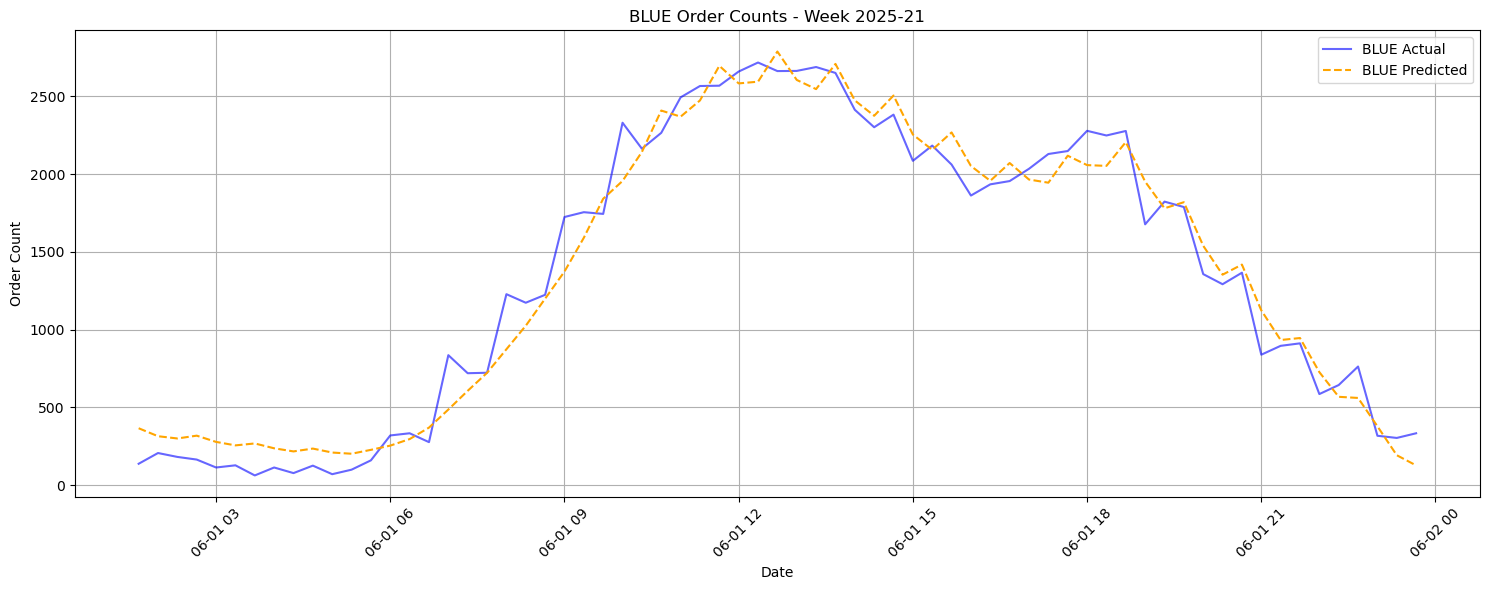

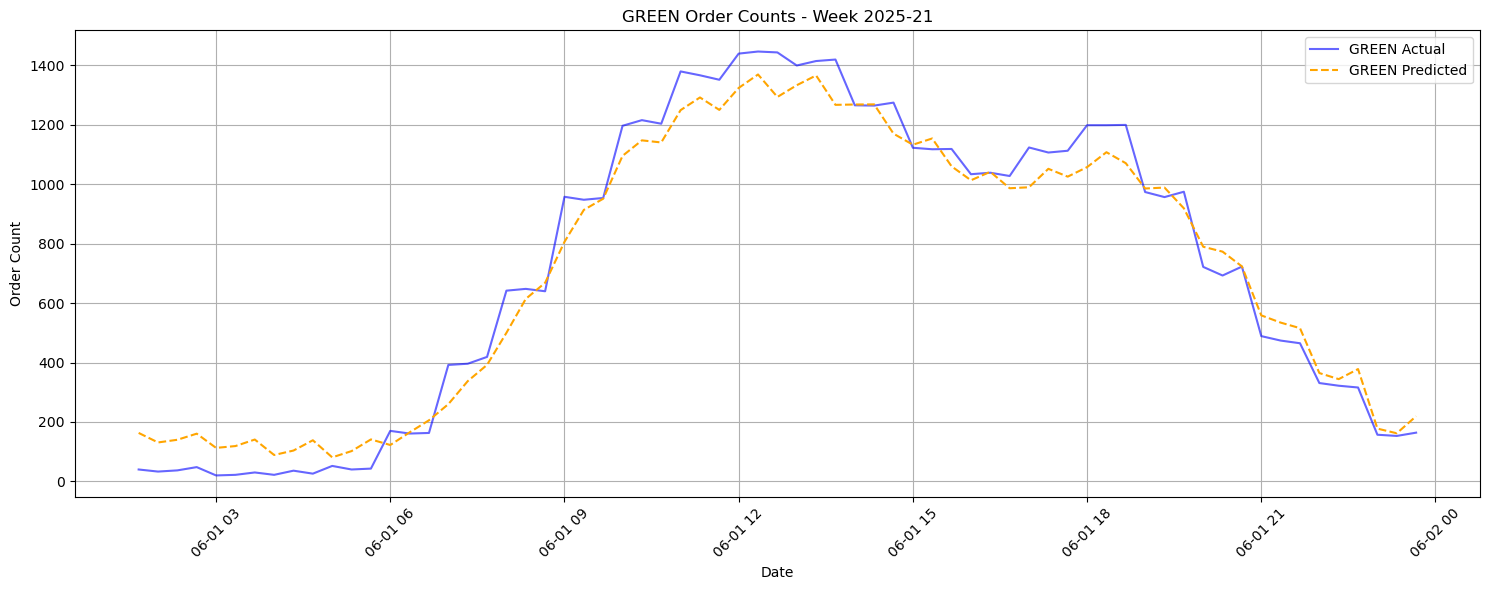

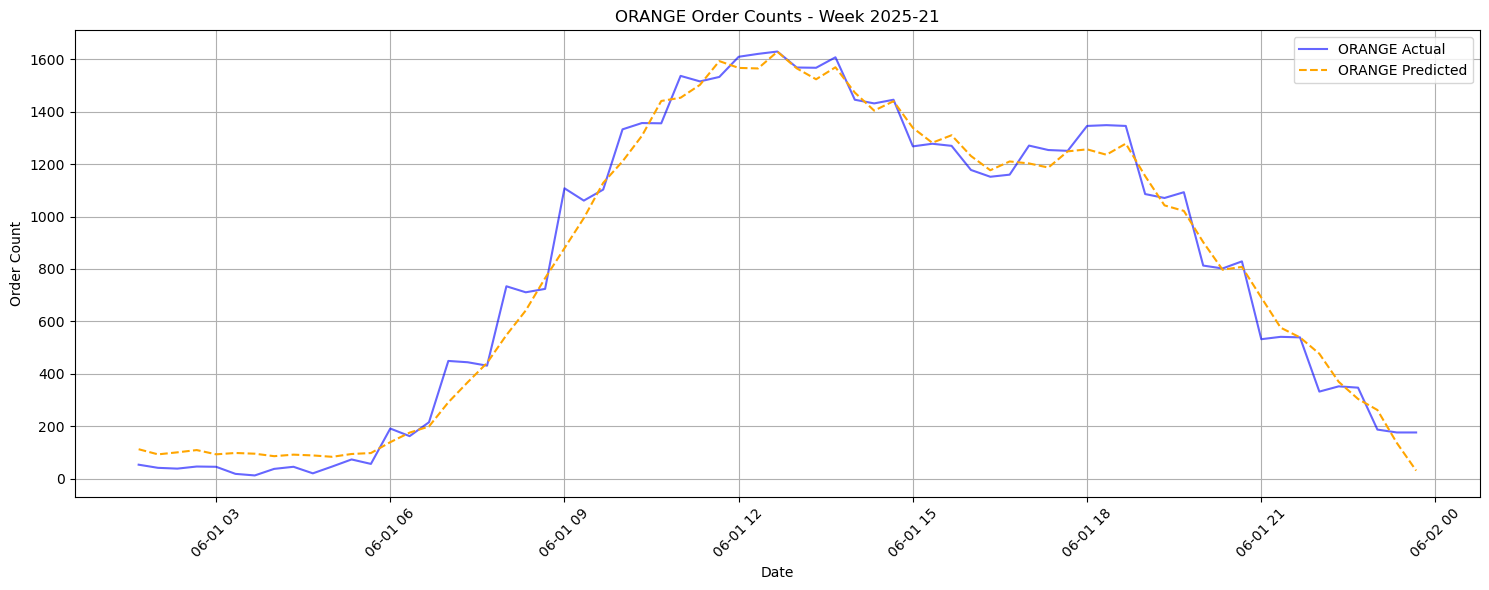

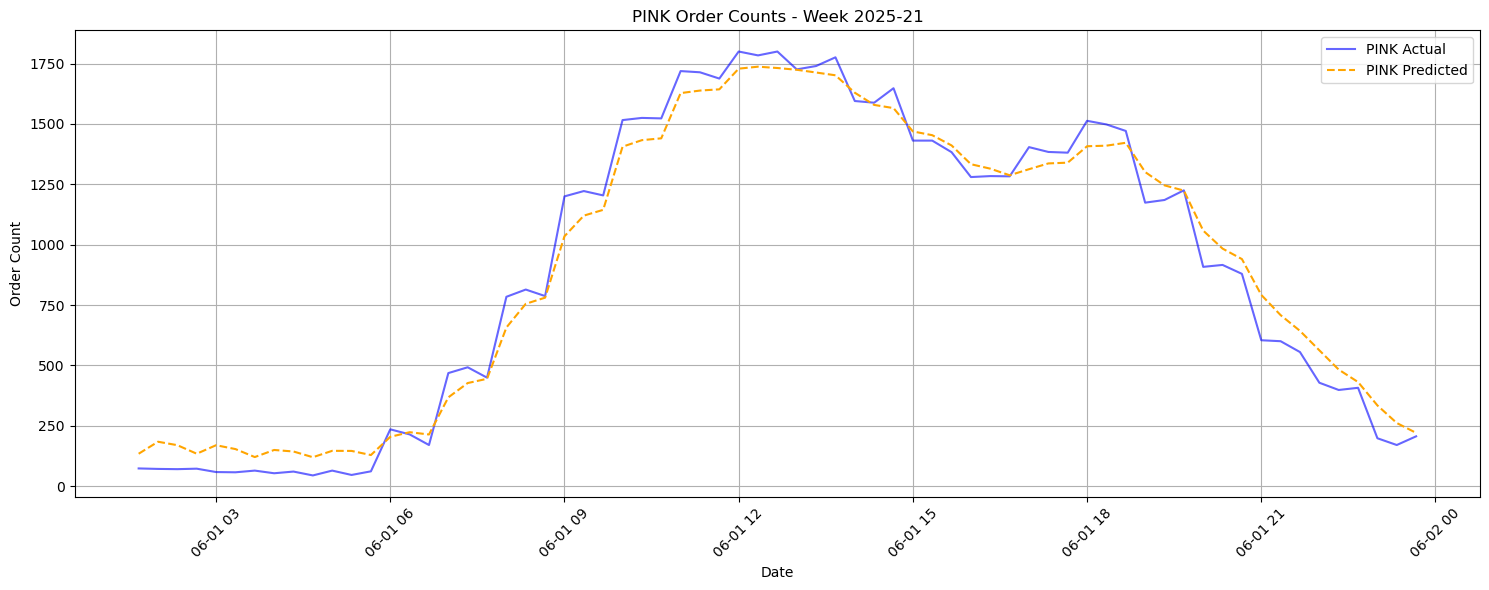

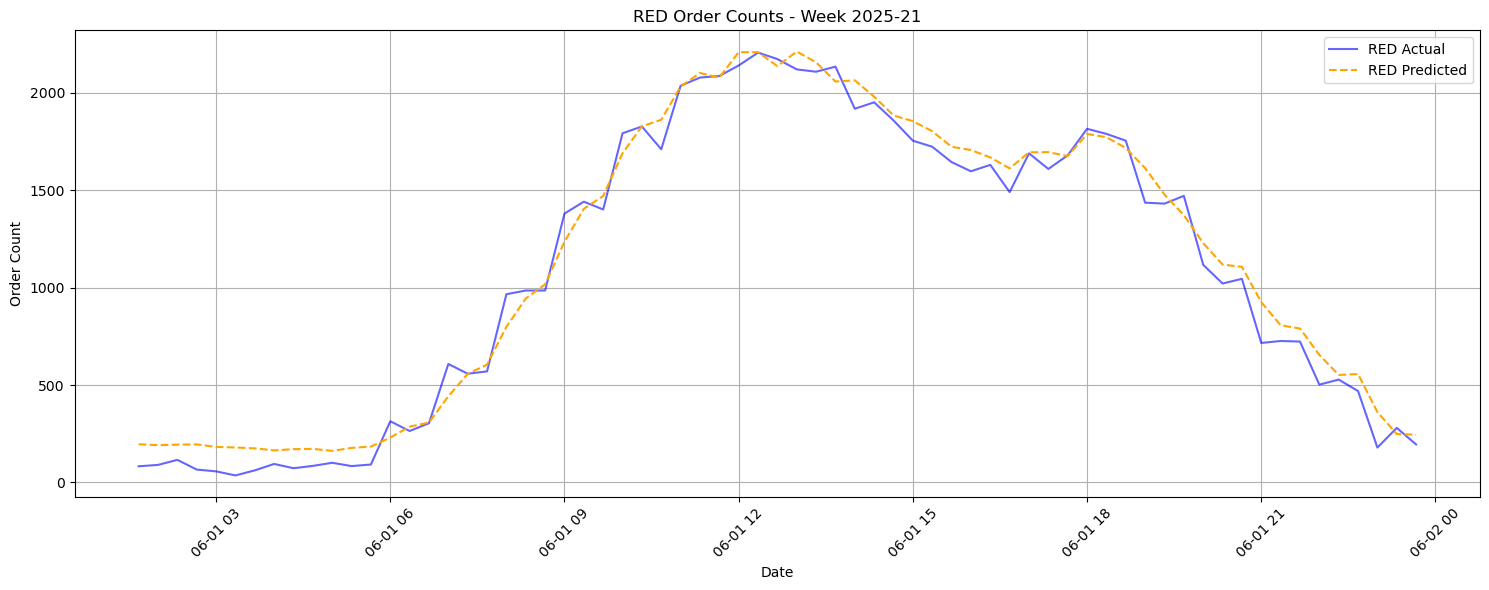

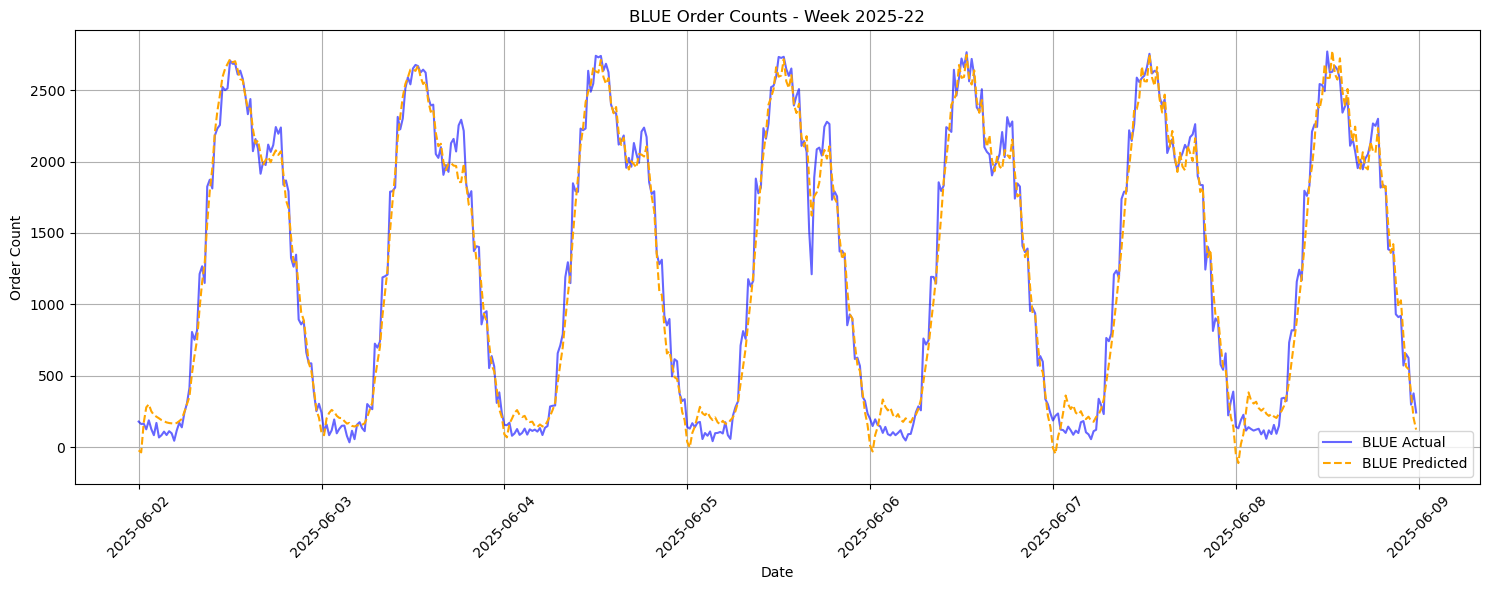

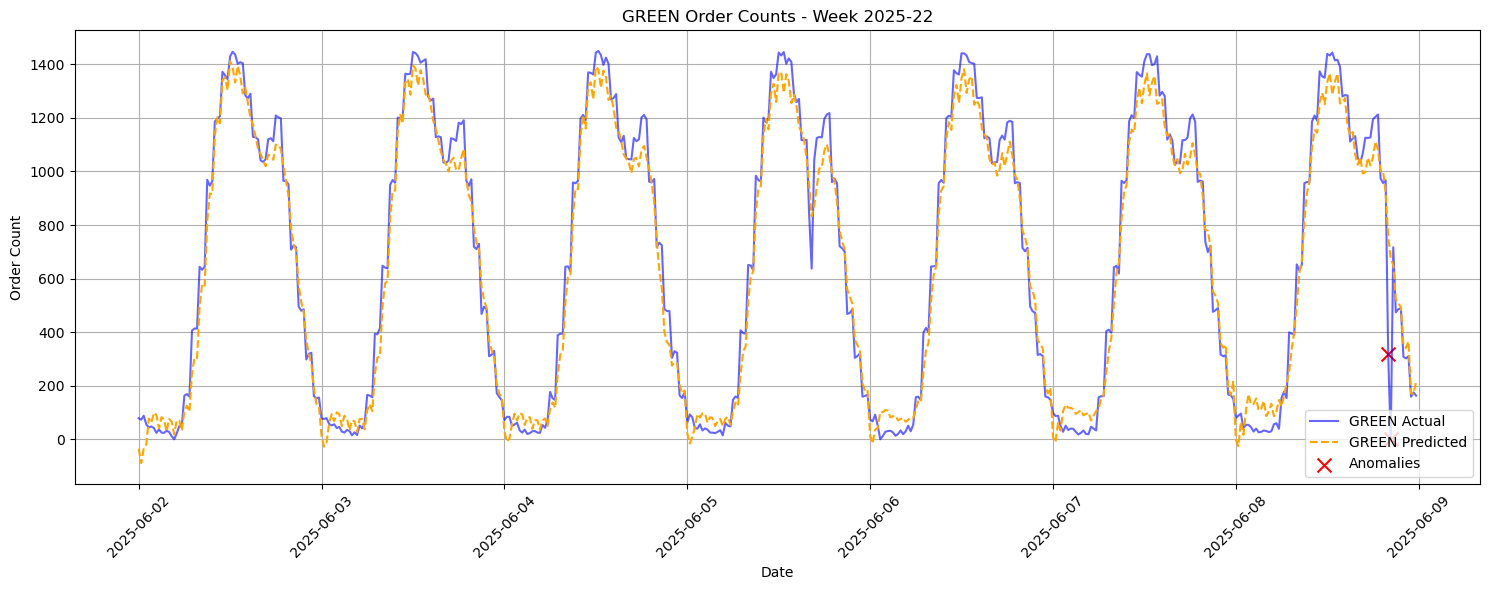

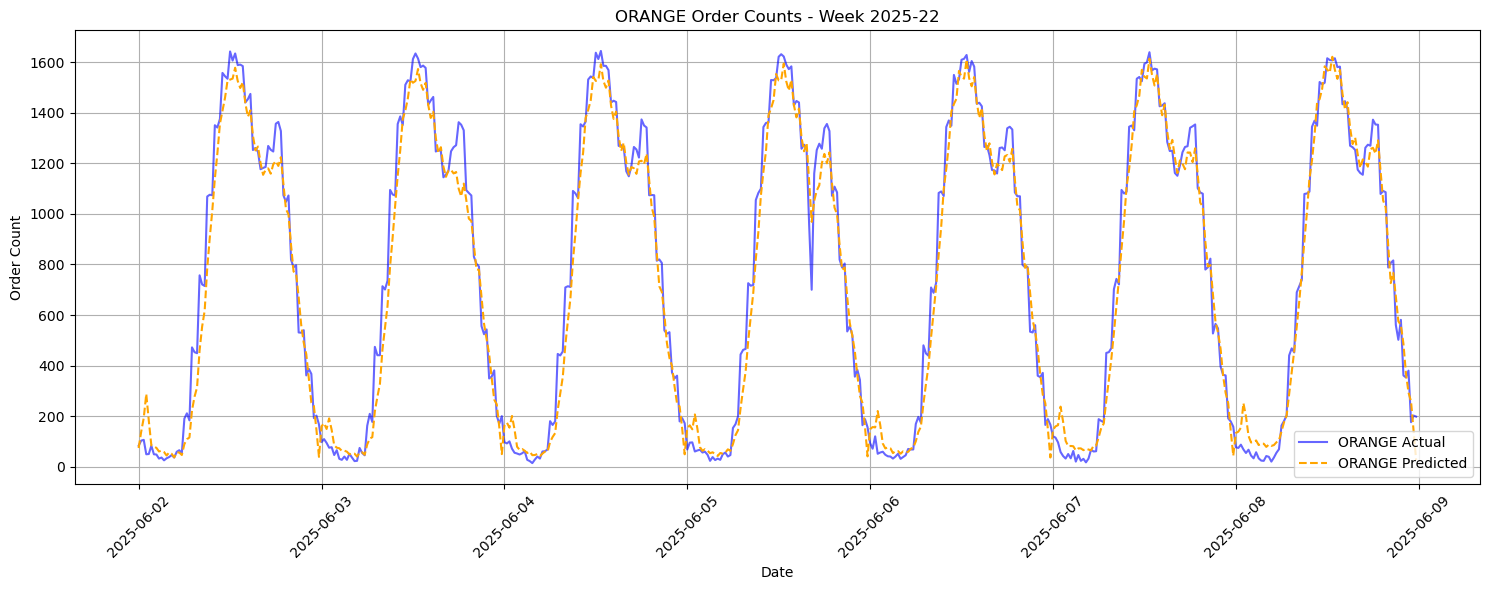

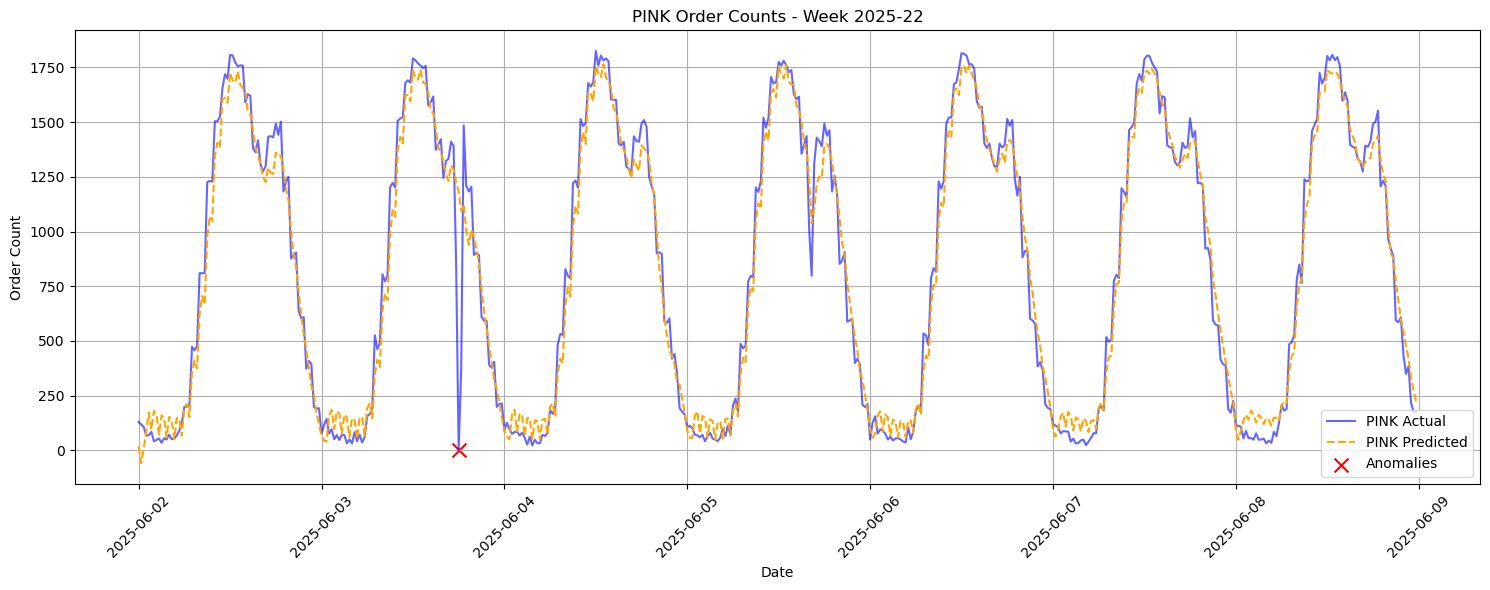

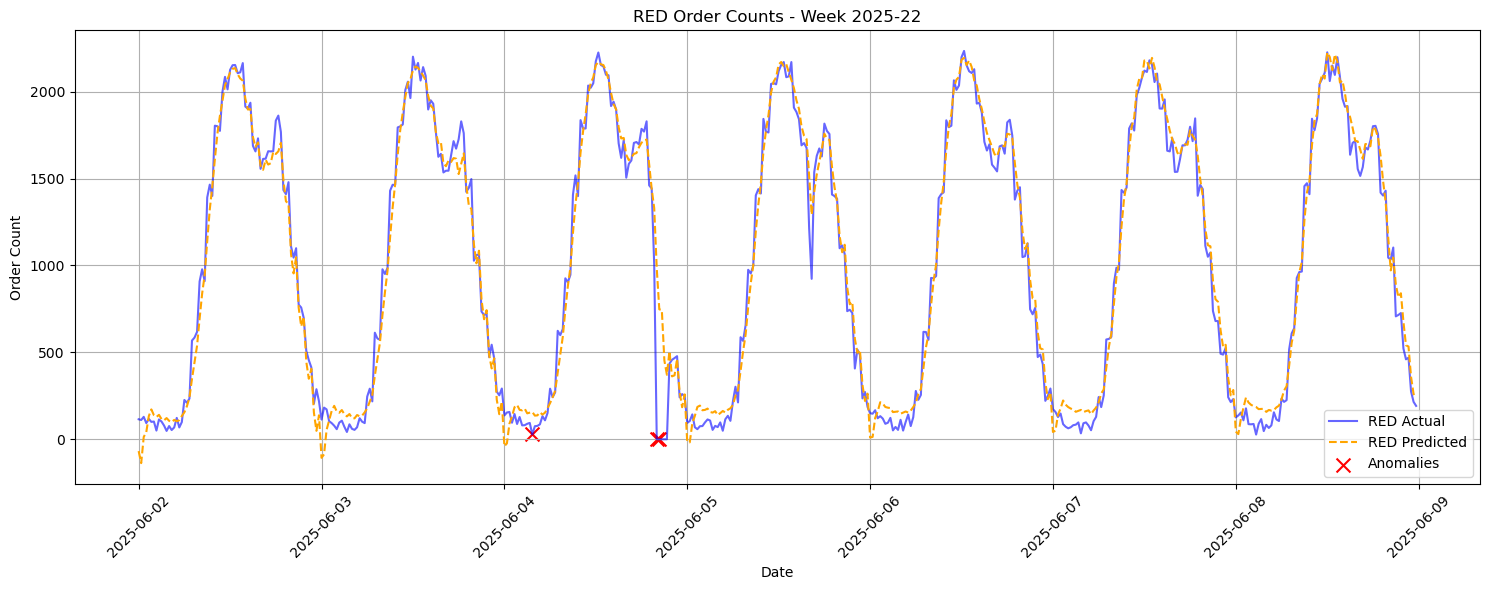

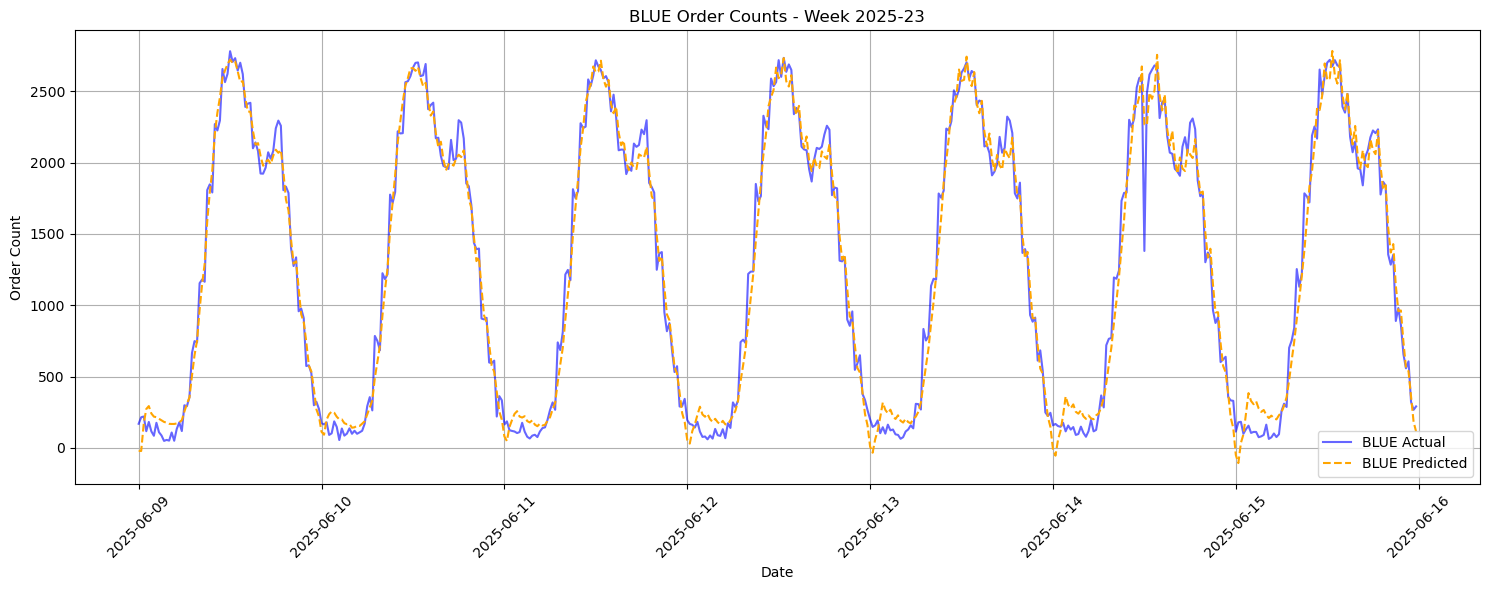

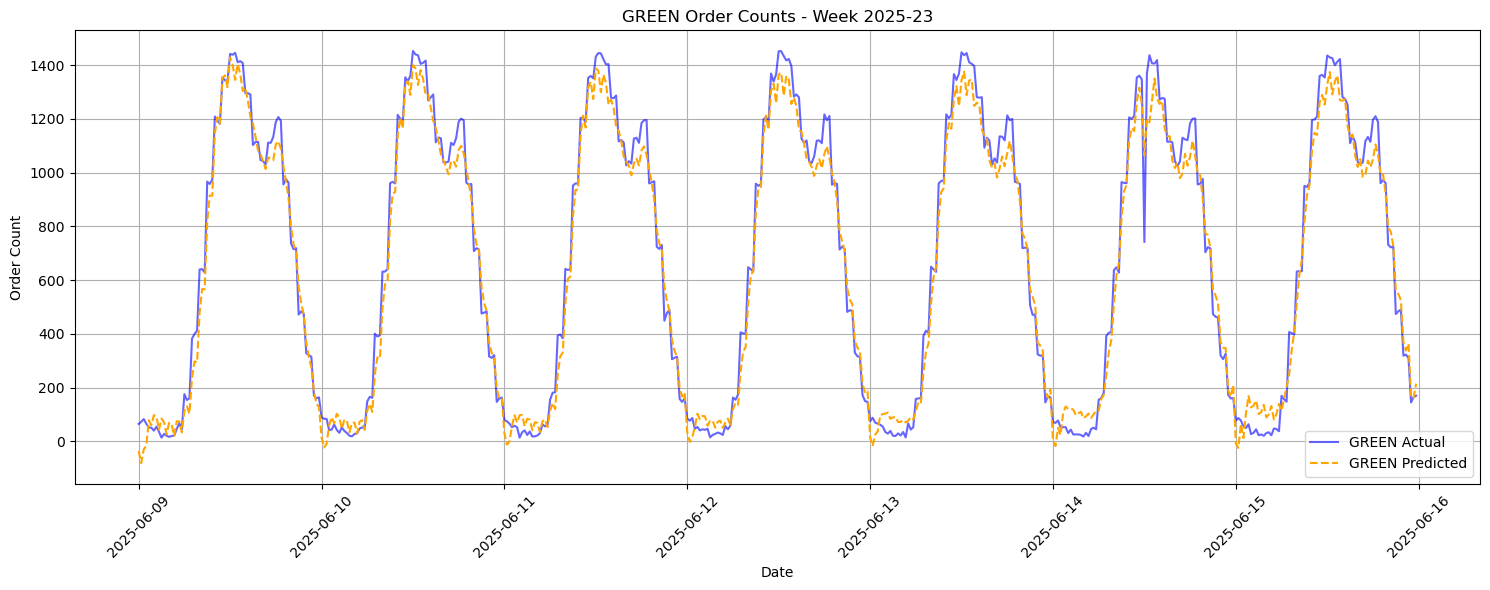

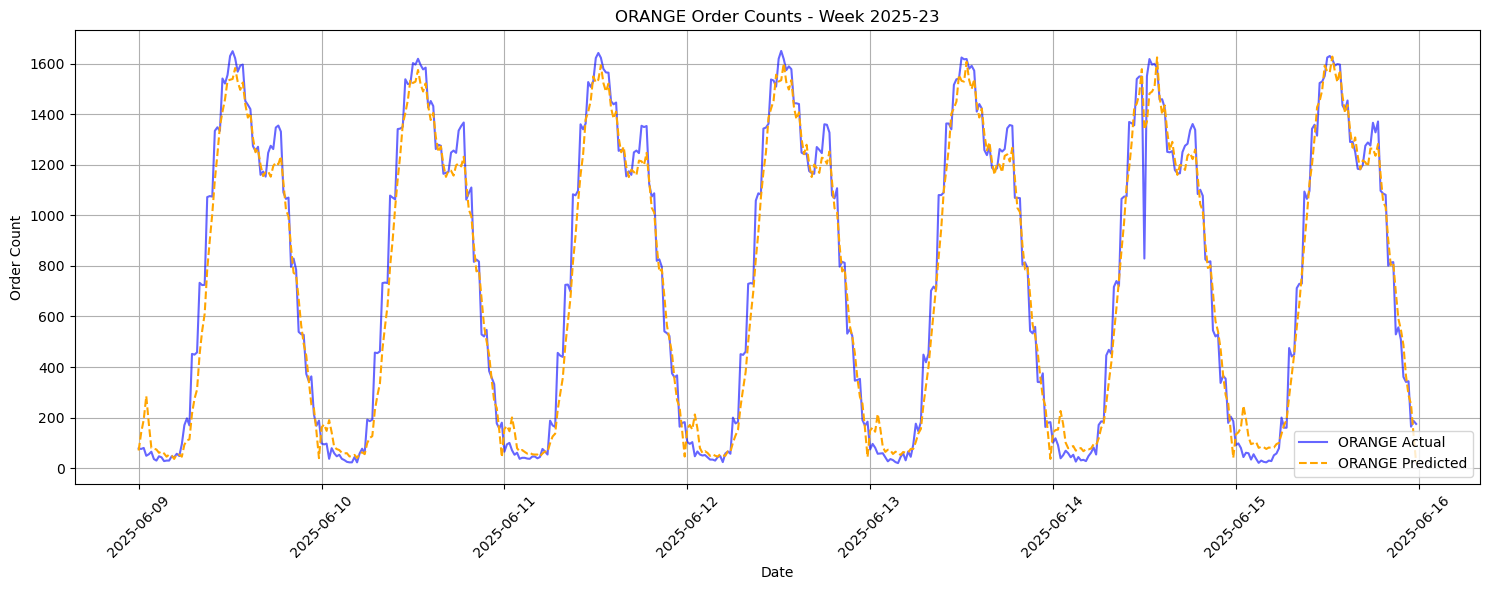

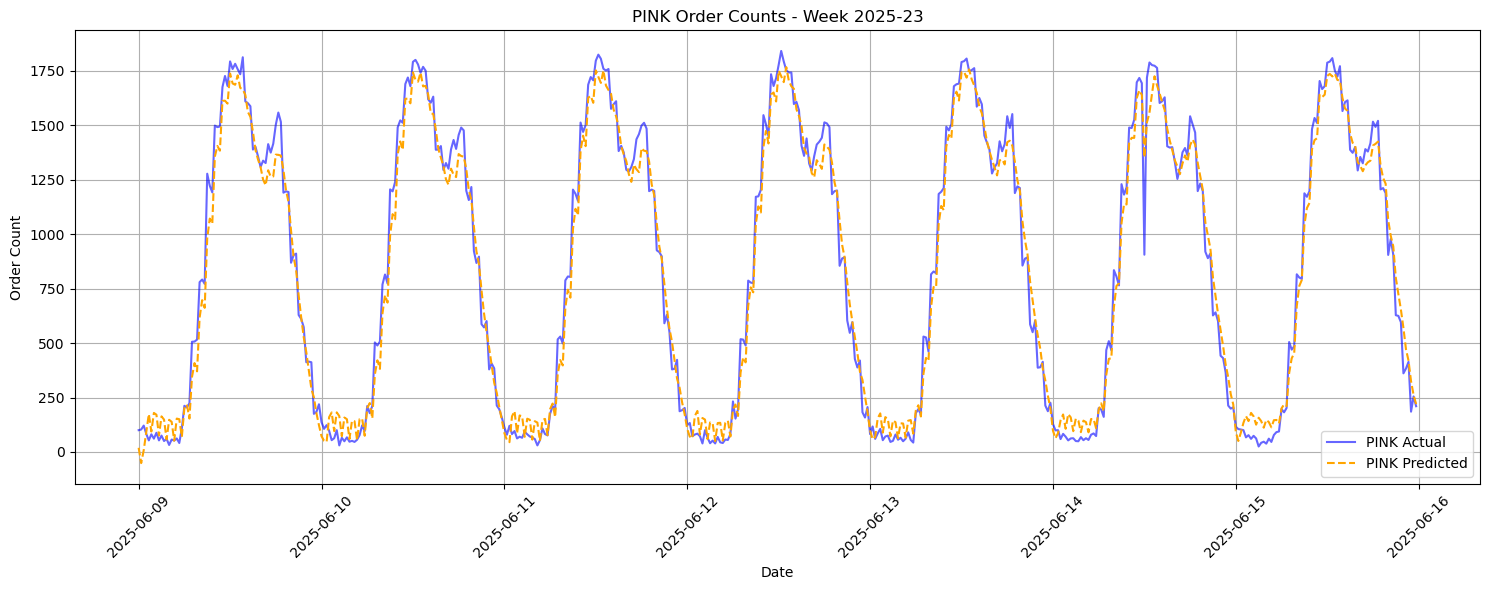

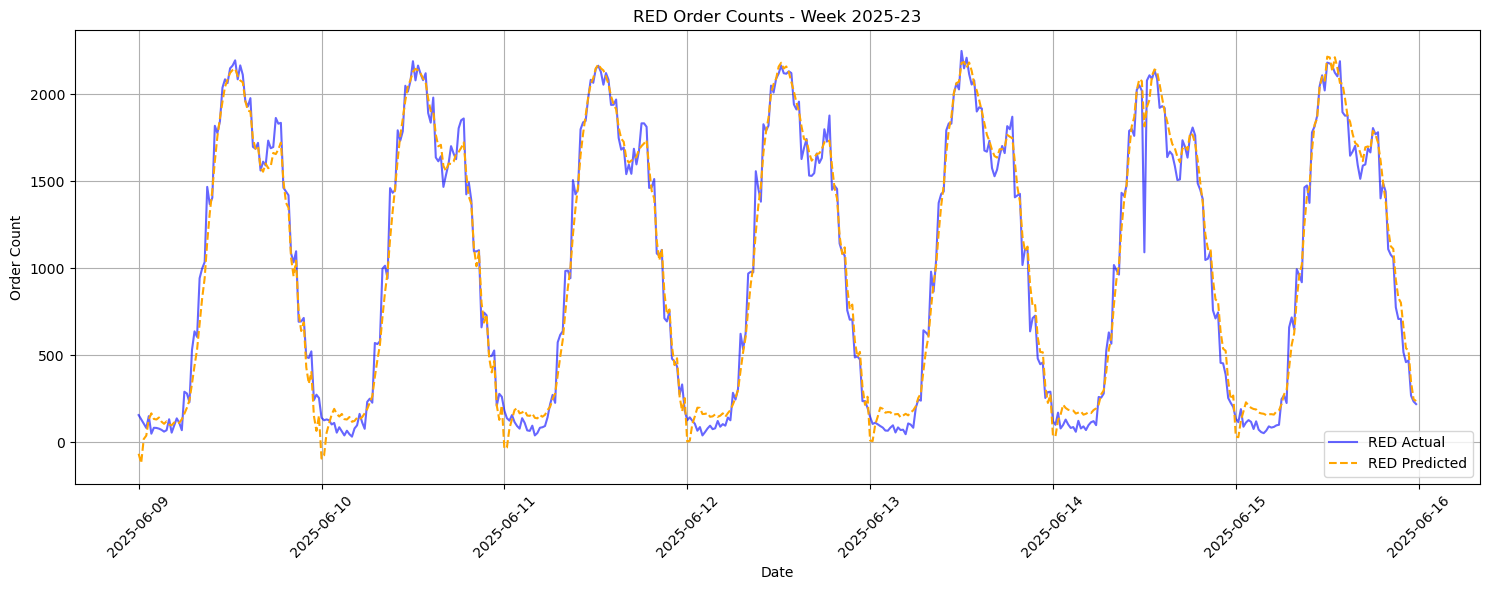

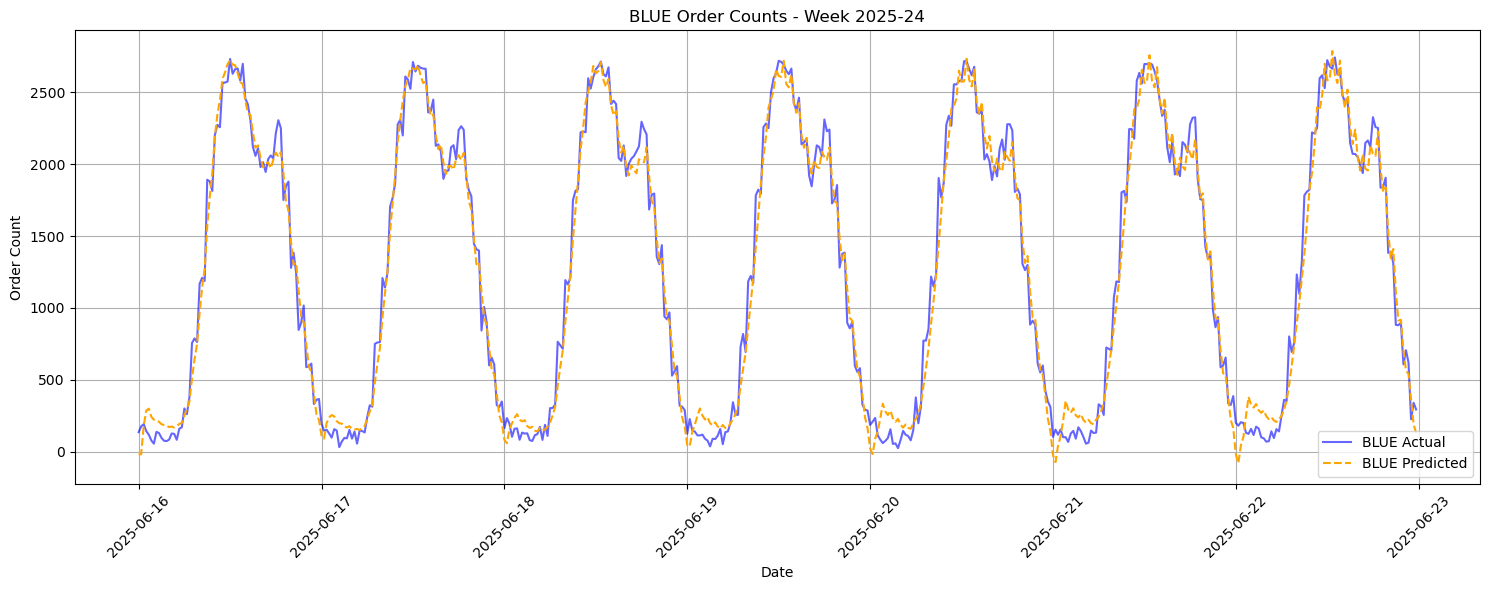

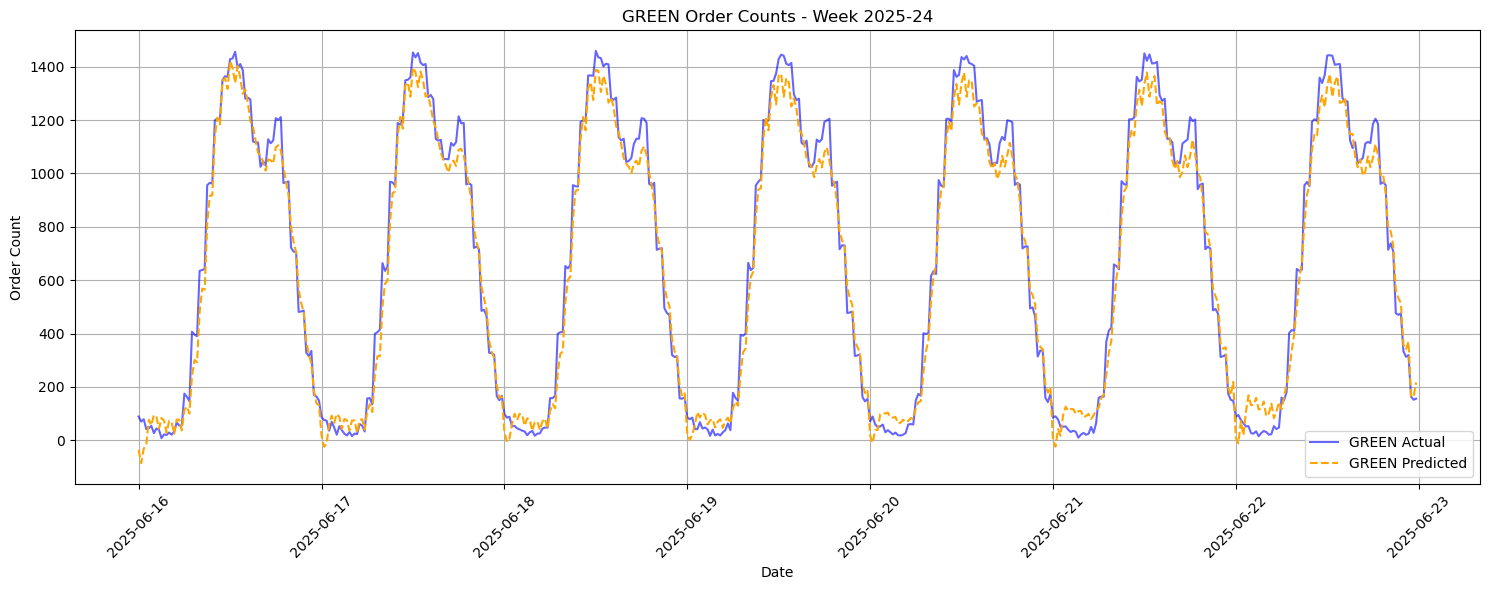

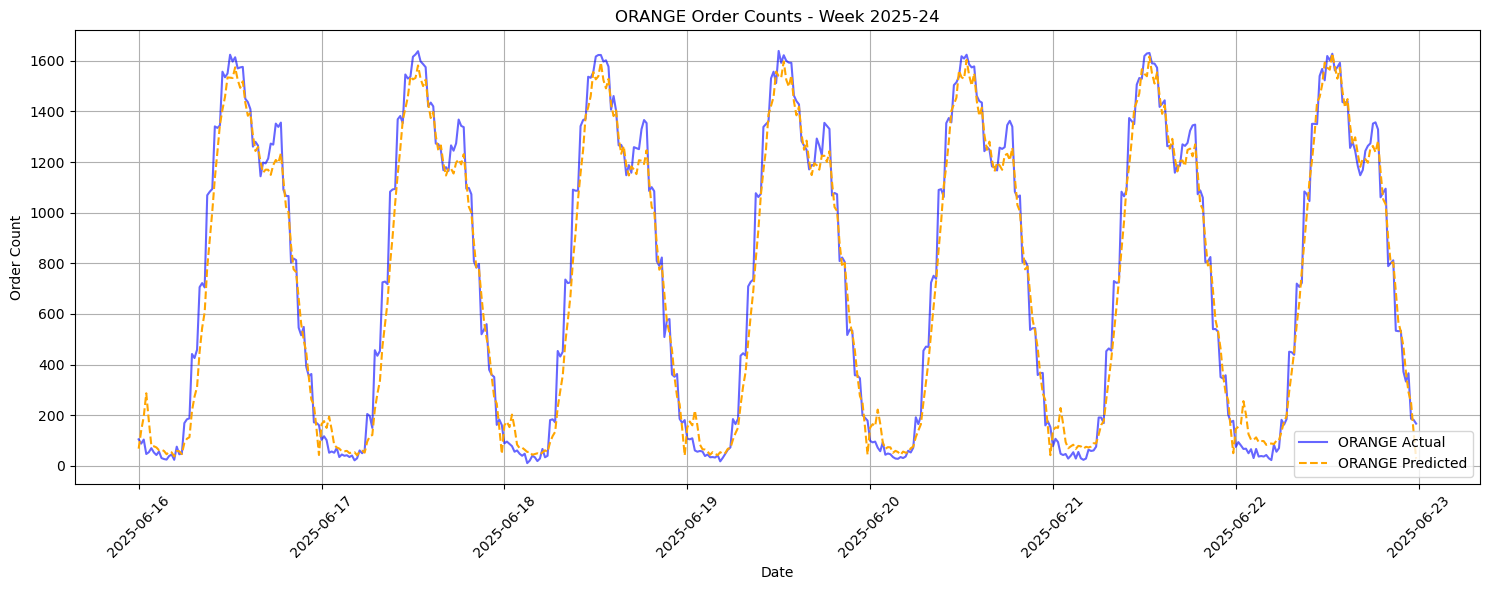

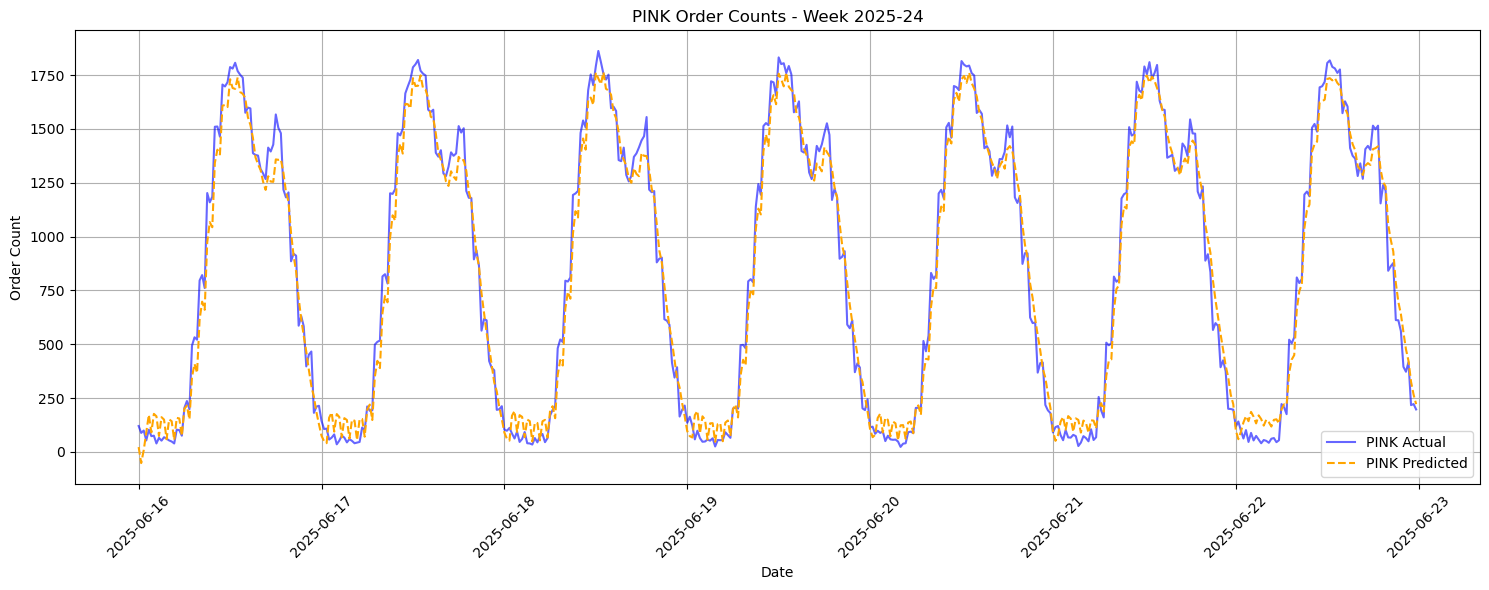

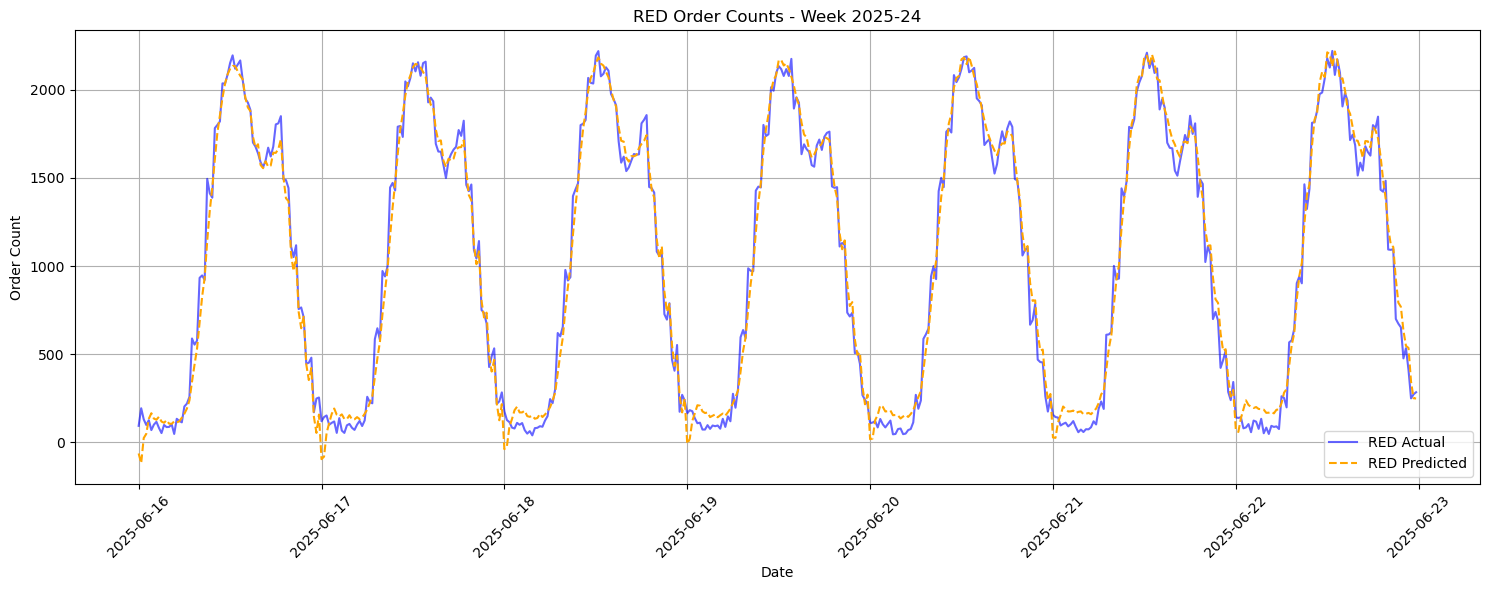

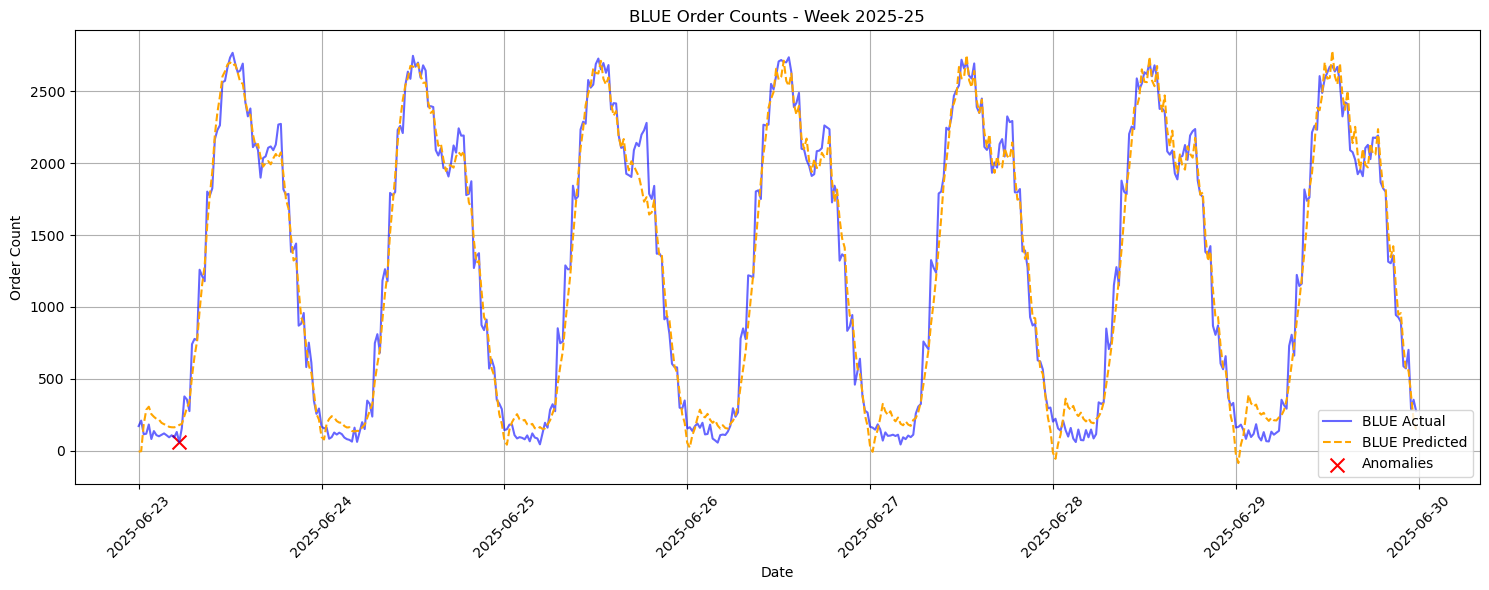

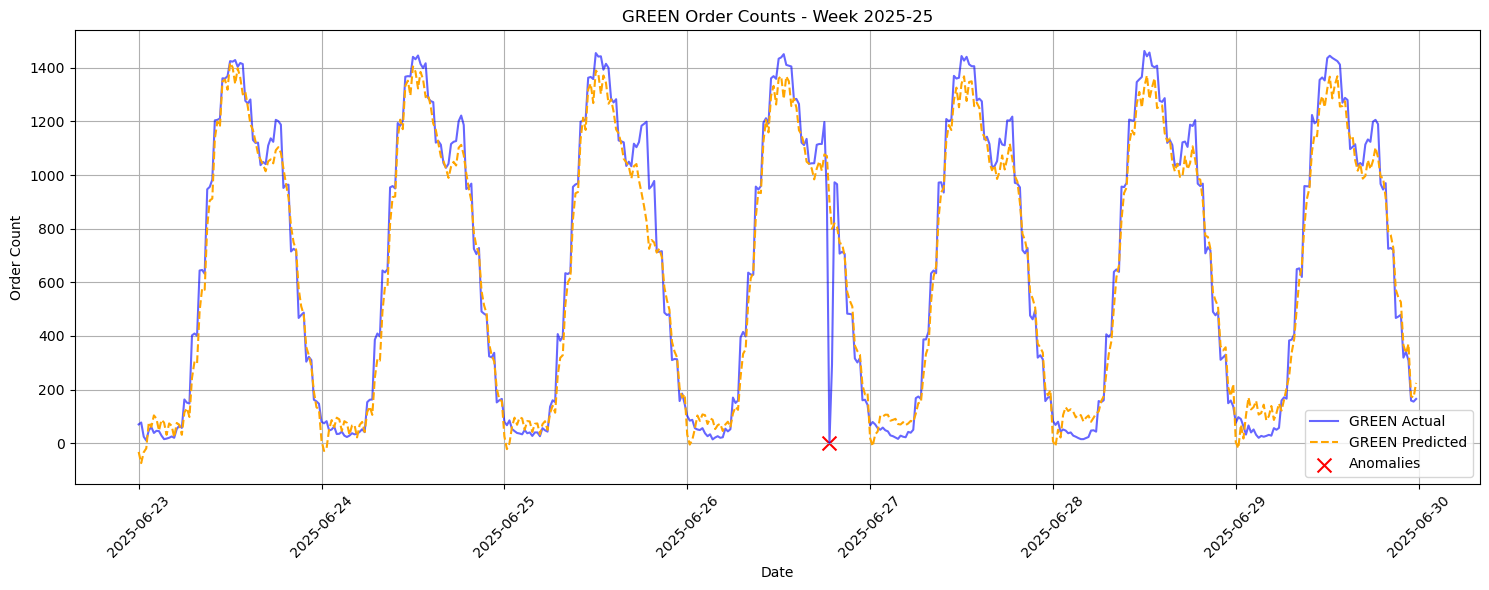

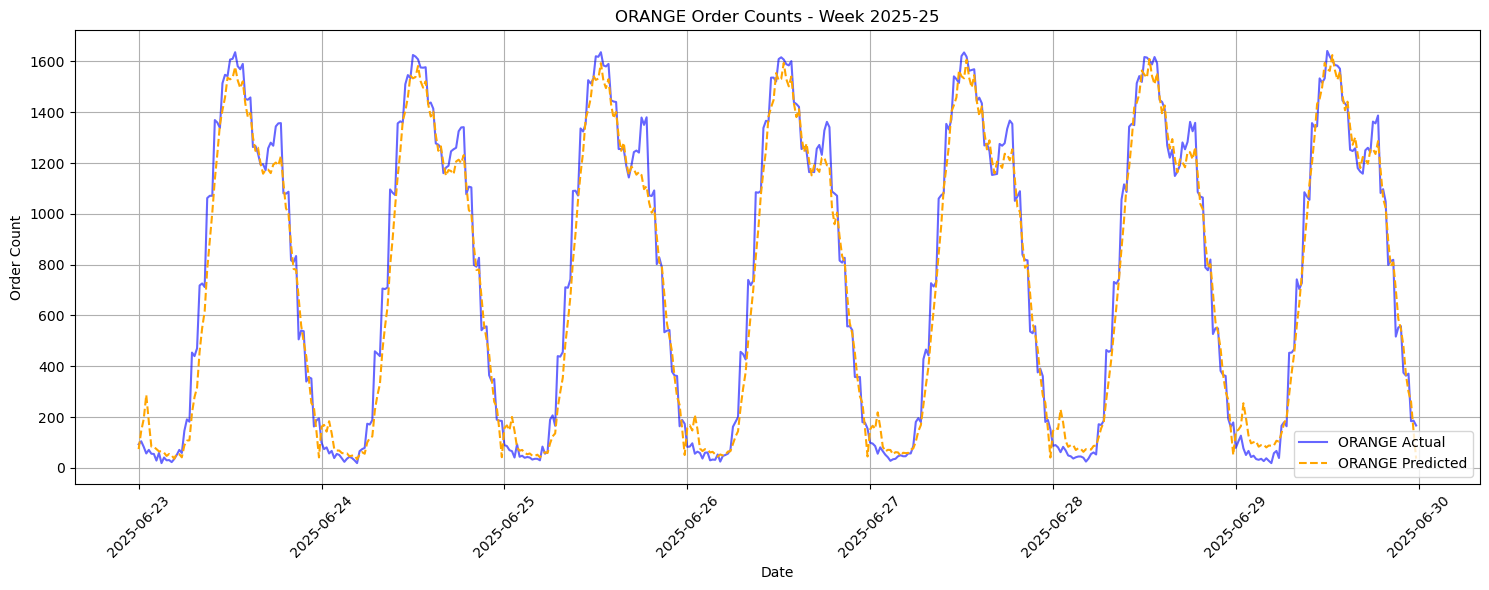

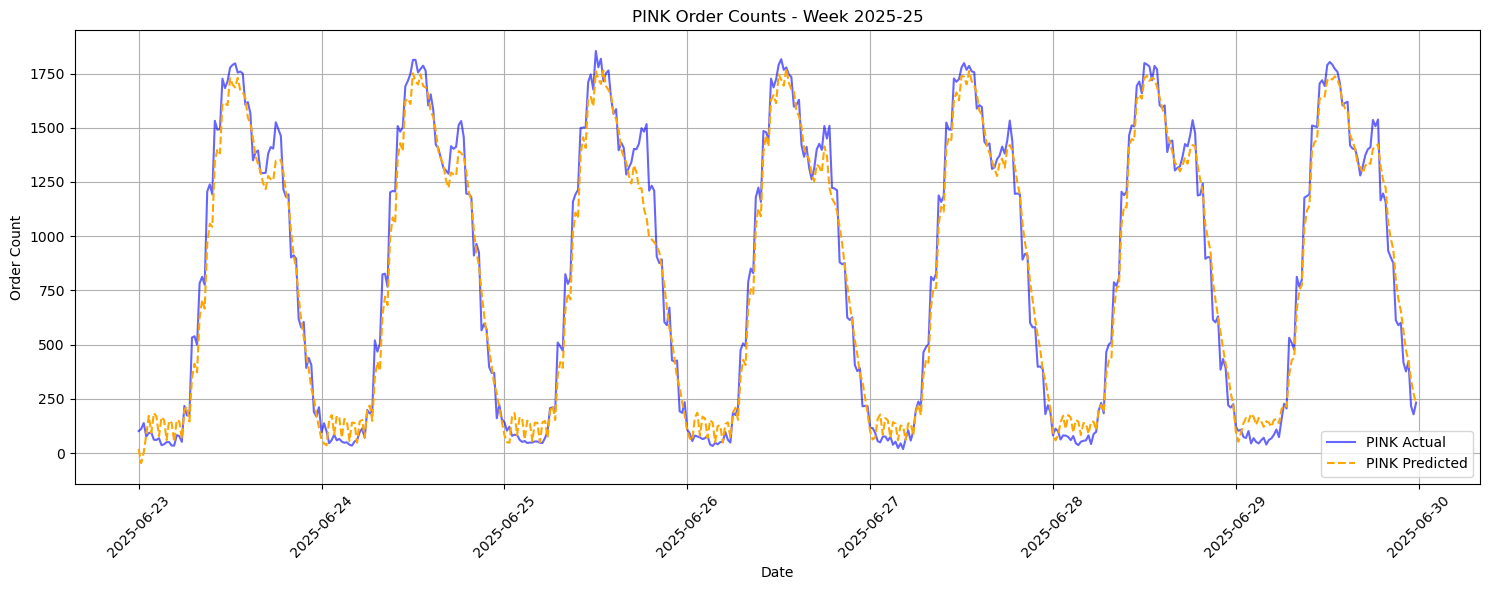

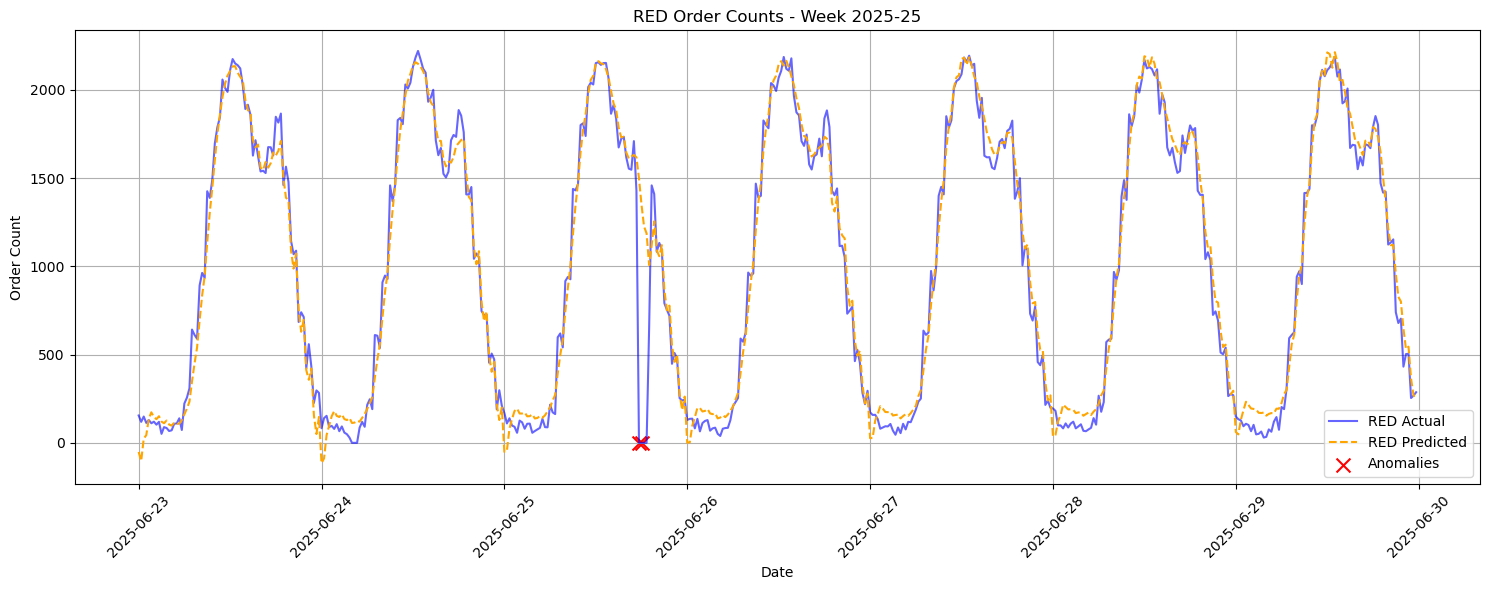

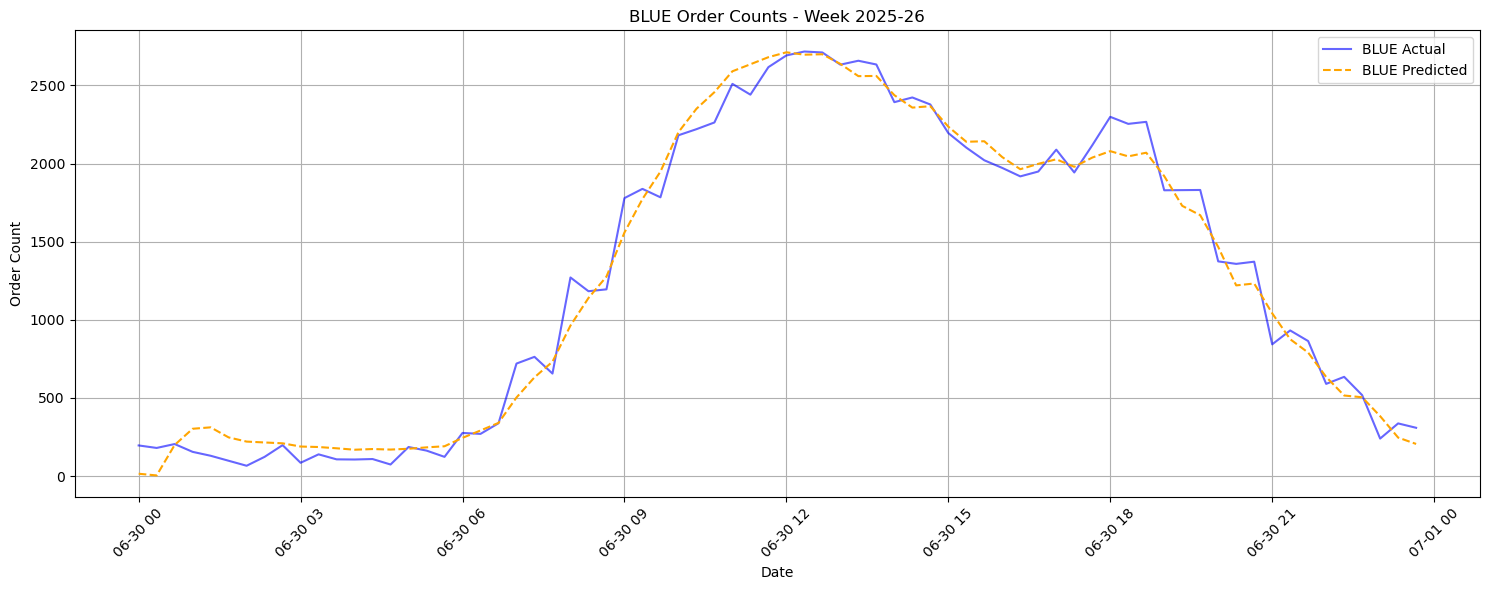

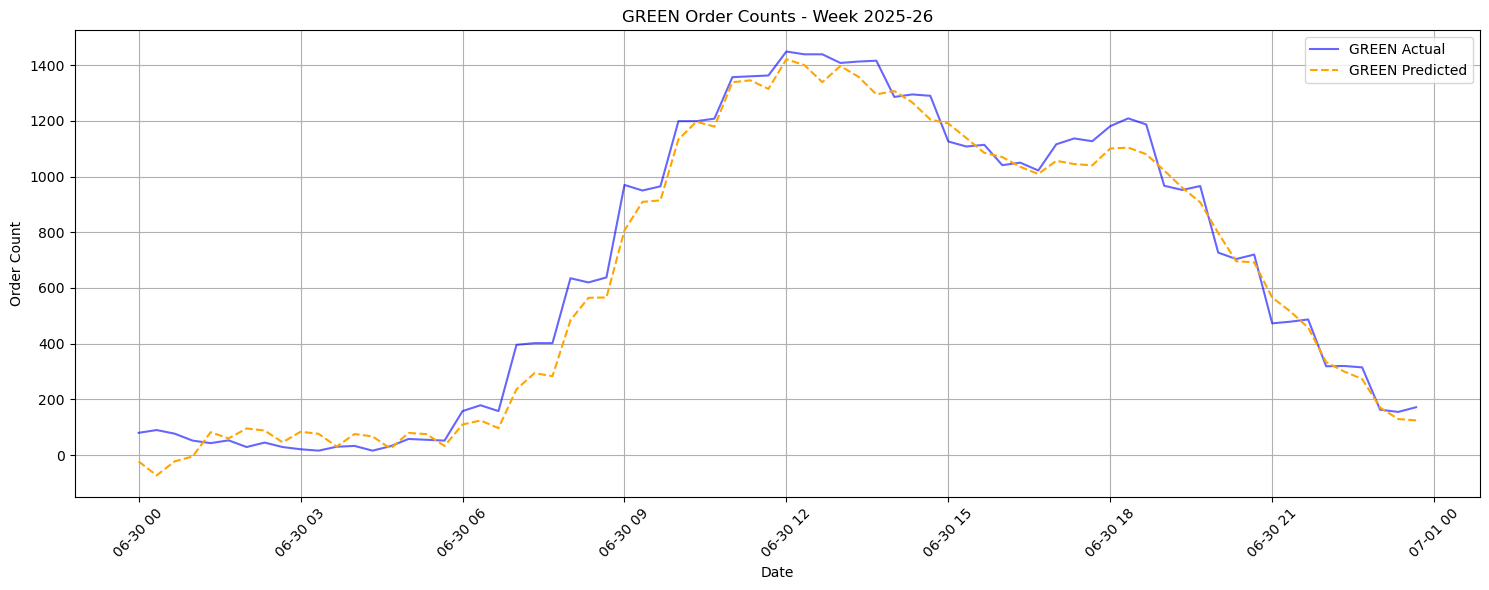

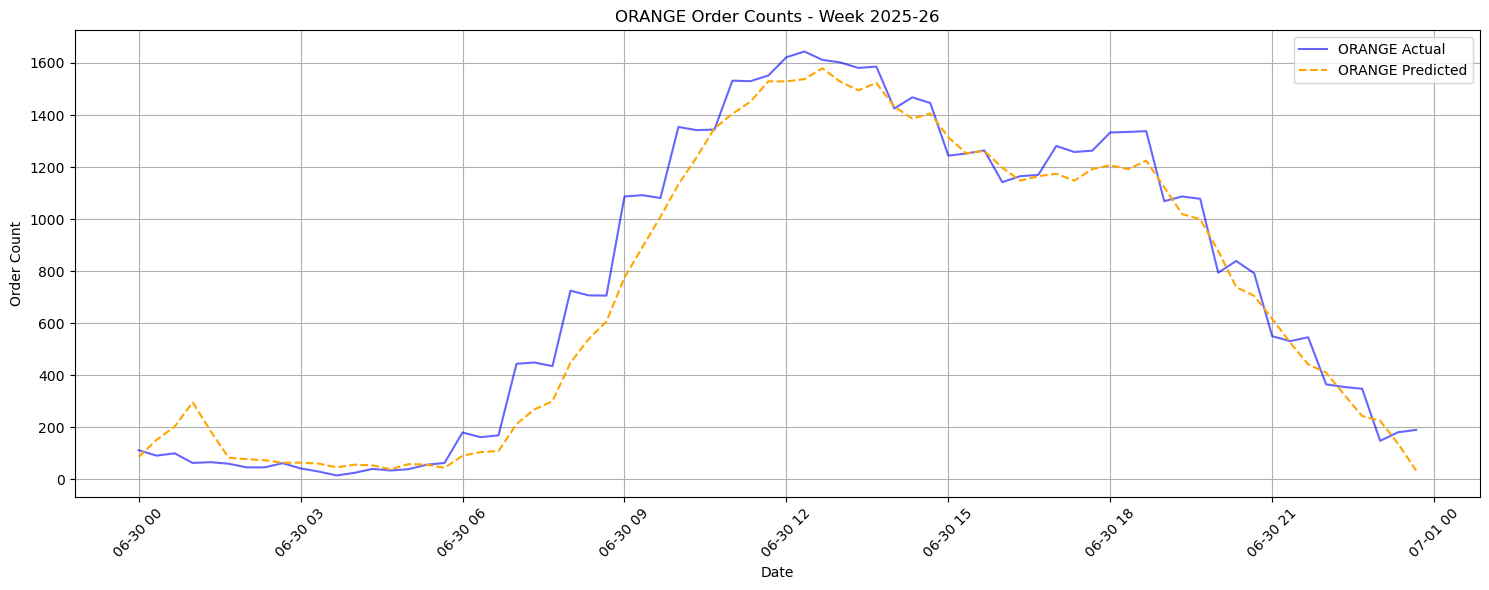

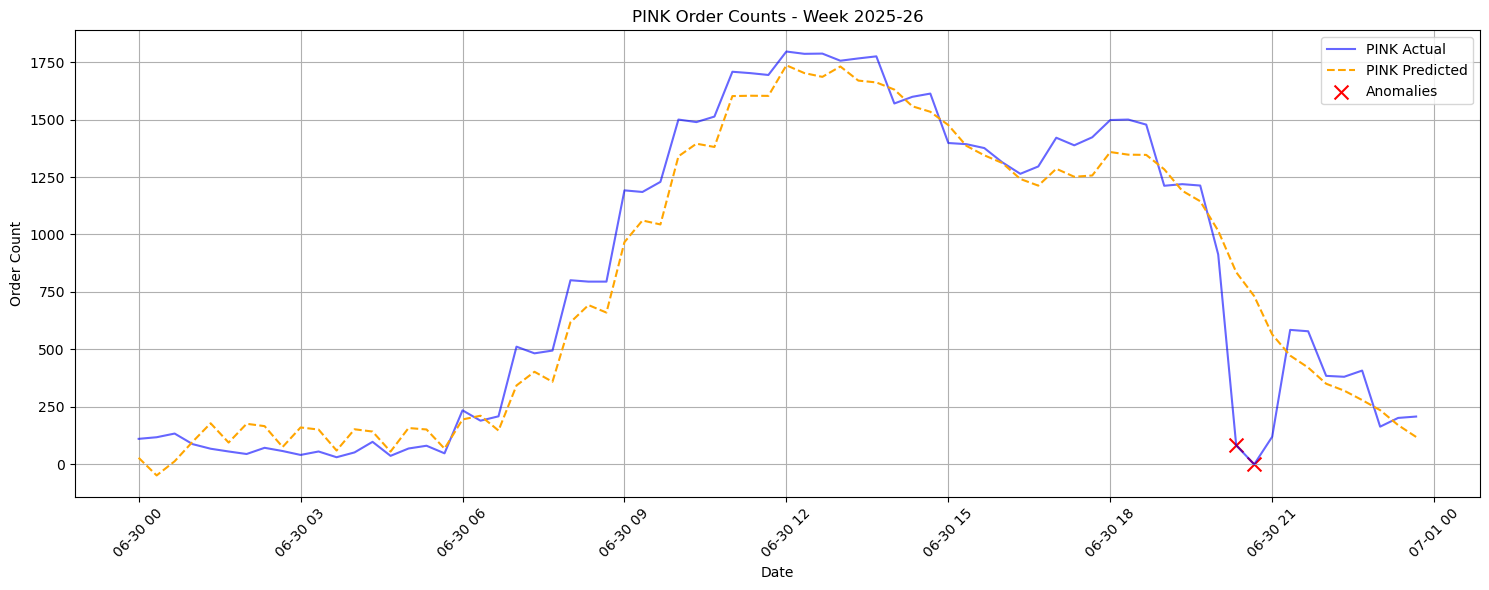

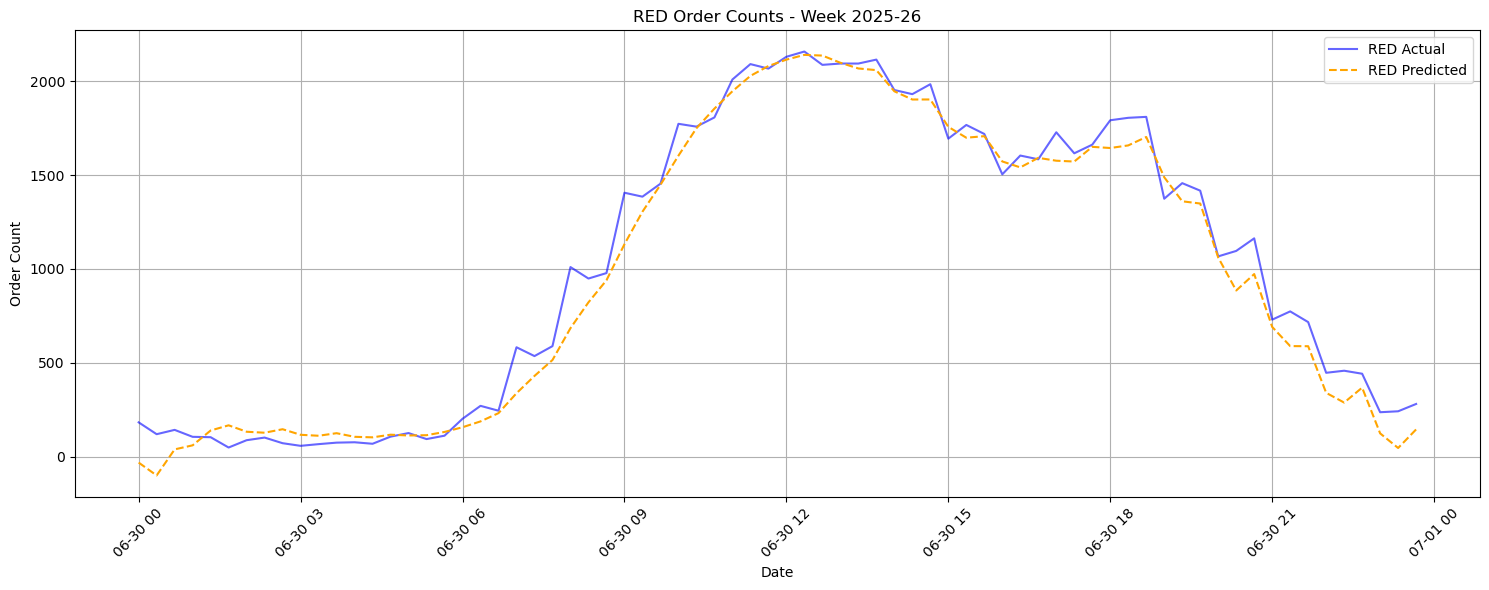

Anomaly detection completed.
Full time series saved to 'full_time_series_20min.csv'.
Plots displayed above for each week and client.

Provide input data for real-time anomaly check (at least 6 rows).
Format example: [{'interval_20min': '2025-06-10 21:00', 'BLUE': 10, 'GREEN': 15, 'ORANGE': 20, 'PINK': 25, 'RED': 30}, ...]


Enter your data as a Python list of dictionaries:  [     {"interval_20min": "2025-07-01 10:20", "BLUE": 12, "GREEN": 18, "ORANGE": 22, "PINK": 28, "RED": 30},     {"interval_20min": "2025-07-01 10:40", "BLUE": 10, "GREEN": 16, "ORANGE": 20, "PINK": 26, "RED": 32},     {"interval_20min": "2025-07-01 11:00", "BLUE": 11, "GREEN": 15, "ORANGE": 21, "PINK": 25, "RED": 29},     {"interval_20min": "2025-07-01 11:20", "BLUE": 13, "GREEN": 17, "ORANGE": 23, "PINK": 27, "RED": 31},     {"interval_20min": "2025-07-01 11:40", "BLUE": 9, "GREEN": 14, "ORANGE": 19, "PINK": 24, "RED": 28},     {"interval_20min": "2025-07-01 12:20", "BLUE": 2, "GREEN": 1, "ORANGE": 0, "PINK": 3, "RED": 4} ]



Anomaly Check Result:
Timestamp: 2025-07-01 12:20
BLUE:
  Actual: 2
  Predicted: 23.45
  Is Anomaly: False
GREEN:
  Actual: 1
  Predicted: 0.00
  Is Anomaly: False
ORANGE:
  Actual: 0
  Predicted: 19.23
  Is Anomaly: True
PINK:
  Actual: 3
  Predicted: 0.00
  Is Anomaly: False
RED:
  Actual: 4
  Predicted: 28.27
  Is Anomaly: True


In [15]:
if __name__ == "__main__":
    df = load_and_preprocess_data('ecommerce_order_data.csv')
    
    # Train initial model
    model, scaler, features = train_lstm_autoencoder(df, epochs=15)
    
    # Simulate new data - one day
    new_data_date = '2025-07-01'
    new_data = df[df['interval_20min'].dt.date == pd.to_datetime(new_data_date).date()]
    
    # Update model if new data exists
    if not new_data.empty:
        model = update_lstm_model(new_data, 'lstm_autoencoder_20min.keras', scaler, features, epochs=2)
    
    # Detect anomalies
    result_df, anomalies = detect_anomalies(df, model, scaler, features, p_threshold=0.001, magnitude_threshold=0.5)
    # Plot anomalies
    plot_anomalies(result_df, anomalies)
    
    result_df['datetime'] = result_df['interval_20min'].dt.strftime('%Y-%m-%d %H:%M')
    output_cols = ['datetime'] + [col for col in result_df.columns if col.startswith(('BLUE', 'GREEN', 'ORANGE', 'PINK', 'RED')) or col.endswith(('_pred', '_p_value', '_anomaly'))]
    result_df[output_cols].to_csv('full_time_series_20min.csv', index=False)
    
    if not anomalies.empty:
        anomalies = anomalies.reset_index(drop=True)
        anomalies['datetime'] = anomalies['interval_20min'].dt.strftime('%Y-%m-%d %H:%M')
        report_cols = ['datetime'] + [col for col in anomalies.columns if col.startswith(('BLUE', 'GREEN', 'ORANGE', 'PINK', 'RED')) or col.endswith(('_p_value', '_anomaly'))]
        anomalies[report_cols].to_csv('lstm_anomaly_report_20min.csv', index=False)
    
    print("Anomaly detection completed.")
    print("Full time series saved to 'full_time_series_20min.csv'.")
    print("Plots displayed above for each week and client.")
    if anomalies.empty:
        print("No anomalies detected. Review the plots and 'full_time_series_20min.csv'.")
    
    
    # Example input for anomaly check
    print("\nProvide input data for real-time anomaly check (at least 6 rows).")
    print("Format example: [{'interval_20min': '2025-06-10 21:00', 'BLUE': 10, 'GREEN': 15, 'ORANGE': 20, 'PINK': 25, 'RED': 30}, ...]")
    user_input = input("Enter your data as a Python list of dictionaries: ")
    
    try:
        # Convert string input to list of dictionaries
        input_data = eval(user_input)
        input_df = pd.DataFrame(input_data)
        
        # Check for anomalies
        result = check_input_anomaly(input_df, model, scaler, features, p_threshold=0.001, magnitude_threshold=0.5)
        
        if result:
            print("\nAnomaly Check Result:")
            print(f"Timestamp: {result['timestamp']}")
            for client in ['BLUE', 'GREEN', 'ORANGE', 'PINK', 'RED']:
                print(f"{client}:")
                print(f"  Actual: {result[client]['actual']}")
                print(f"  Predicted: {result[client]['predicted']:.2f}")
                print(f"  Is Anomaly: {result[client]['is_anomaly']}")
    except Exception as e:
        print(f"Error processing input: {e}")
        print("Ensure your input is a valid list of dictionaries with 'interval_20min', 'BLUE', 'GREEN', 'ORANGE', 'PINK', and 'RED' keys.")